# Load image

In [1]:
from preprocess import preprocess_image
import os
import cv2
#Load the model
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
#from skimage.transform import resize
os.chdir("/Users/Thanh/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [2]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
patient_gt_001 = nib.load("patient001_frame01_gt.nii.gz")
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
print(after.shape)
after_gt = preprocess_image(patient_gt_001,spacing_target=(10, 1.25, 1.25),is_seg = True, keep_z_spacing=True)
print(after_gt.shape)

(216, 320, 12)
(216, 320, 12)


[1 1 1 ... 2 2 2]


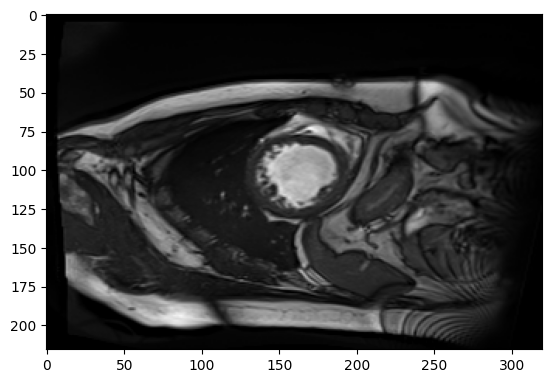

In [3]:
# Convert to RGB
img = cv2.cvtColor(after[:,:,7],cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
img2 = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img2 = img2.astype(np.uint8)
print(img2[img2>0])
plt.imshow(img2)

# Check pixel density for each class

In [4]:
import copy
binary = copy.deepcopy(after_gt[:,:,7])
print(np.unique(binary))
int_mask = []
for i in range(1,4):
    int_mask.append(np.where(binary==i,255,0))

[0. 1. 2. 3.]


(216, 320)


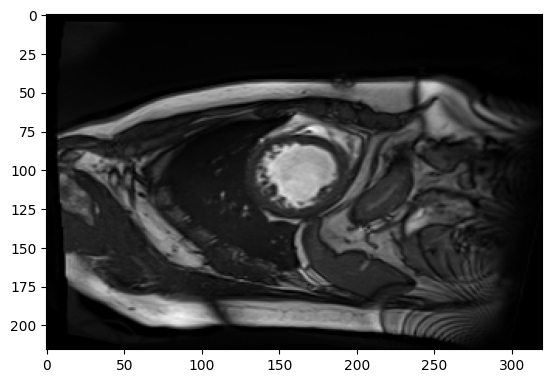

In [5]:
test = cv2.normalize(after[:,:,7], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
test = test.astype(np.uint8)
plt.imshow(test,cmap ="gray")
print(test.shape)

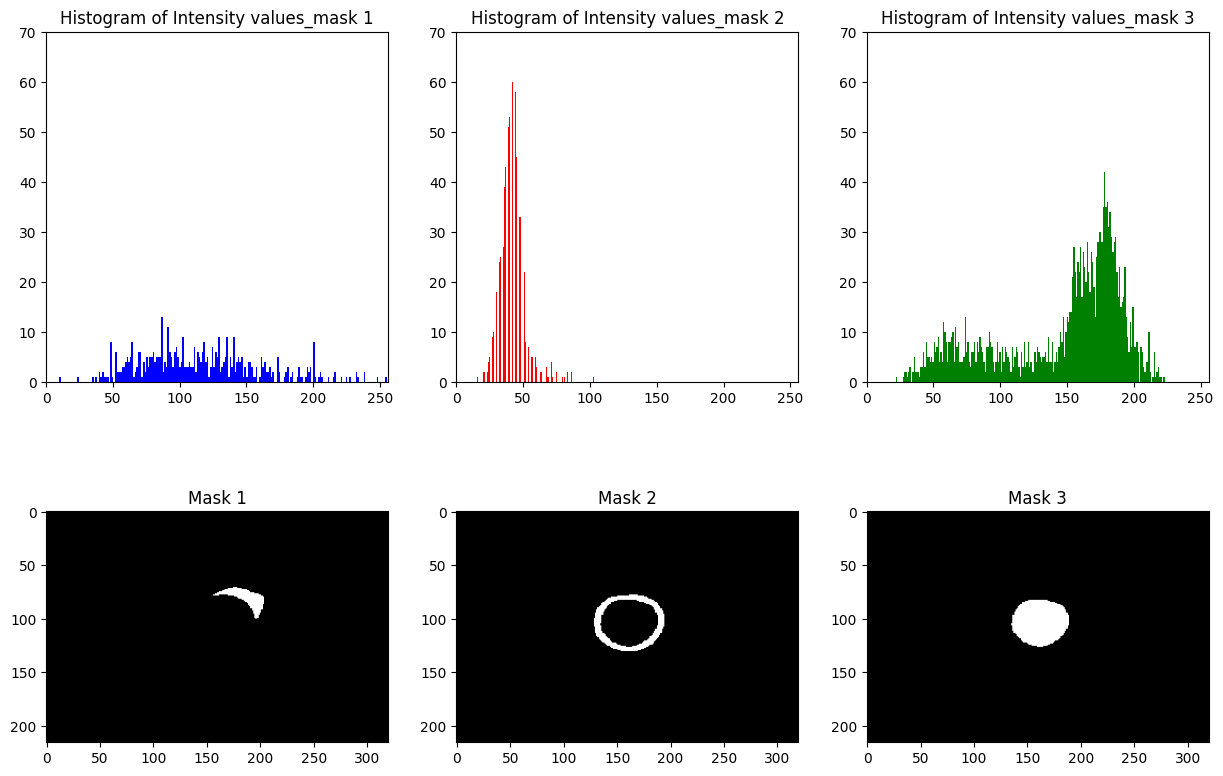

In [6]:
#binary_mask = cv2.bitwise_and(test,test, mask = binary)
#print(binary_mask.shape)
#hist = cv2.calcHist([brain_filter],[0],binary,[256],[0,256])
colors = ['blue','red','green']
fig, ax = plt.subplots(2,3,figsize = (15,10))
for i in range(3):
    ax[0,i].hist(test[int_mask[i]==255], bins=200,log = False,color = colors[i])
    ax[0,i].set_title(f'Histogram of Intensity values_mask {i+1}')
    ax[0,i].set_xlim([0,256])
    ax[0,i].set_ylim([0,70])

    ax[1,i].imshow(int_mask[i],cmap ="gray")
    ax[1,i].set_title(f"Mask {i+1}")
plt.show()

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='green', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Use SAM to predict masks

In [8]:
predictor = SamPredictor(sam)
predictor.set_image(img2)
image_embedding = predictor.get_image_embedding()
image_embedding.shape

torch.Size([1, 256, 64, 64])

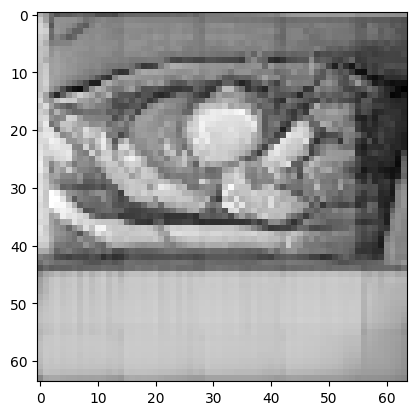

In [9]:
plt.imshow(image_embedding[0,255,:,:],cmap = "gray")

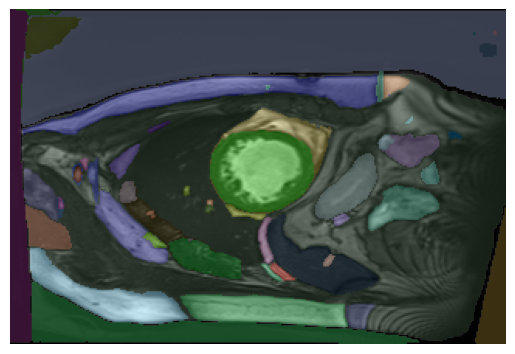

In [33]:
mask_generator = SamAutomaticMaskGenerator(sam,points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)
masks = mask_generator.generate(img2)
plt.figure()
plt.imshow(img2)
show_anns(masks)
plt.axis('off')
plt.show() 

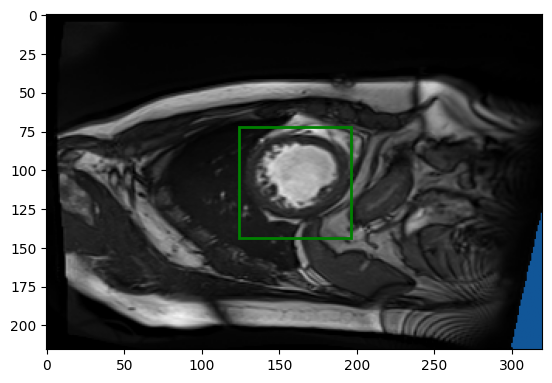

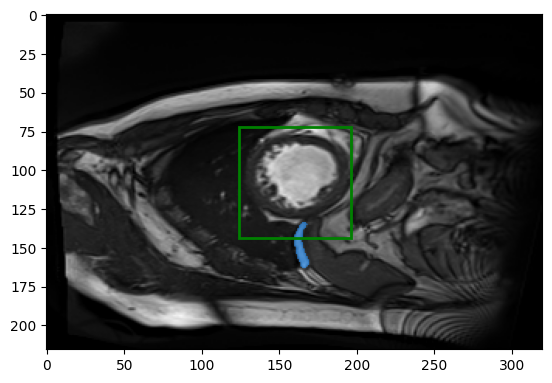

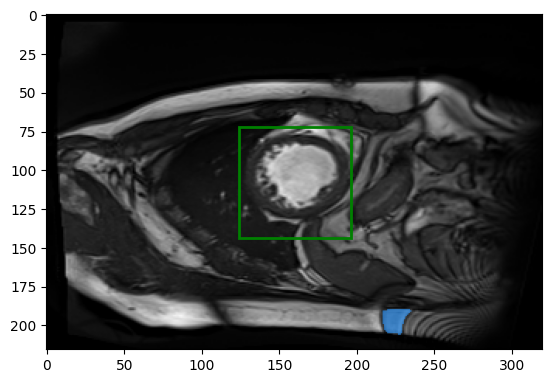

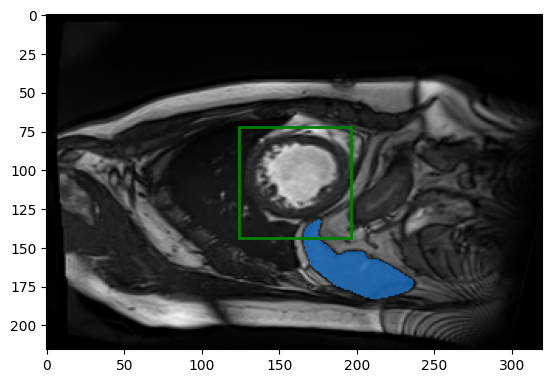

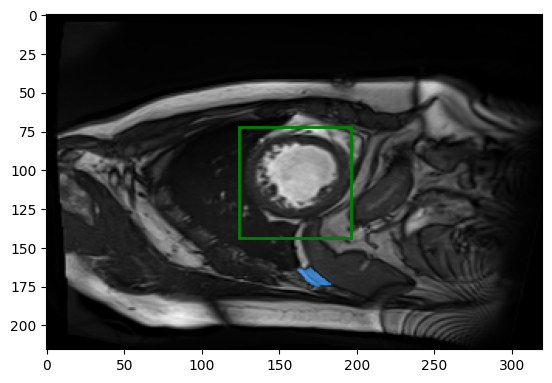

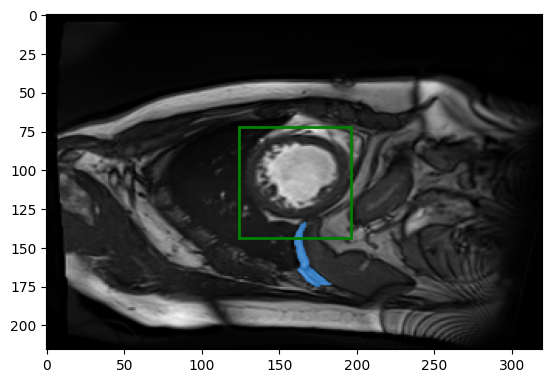

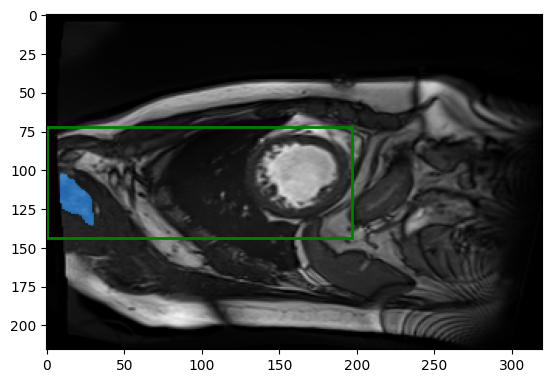

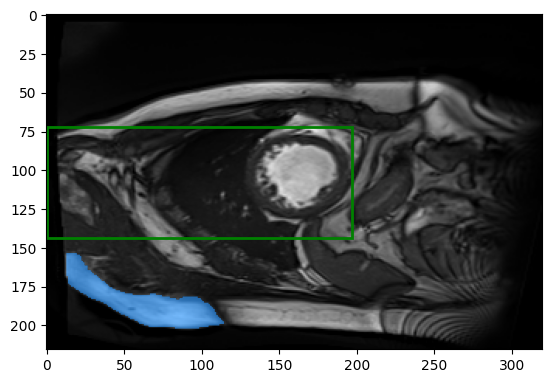

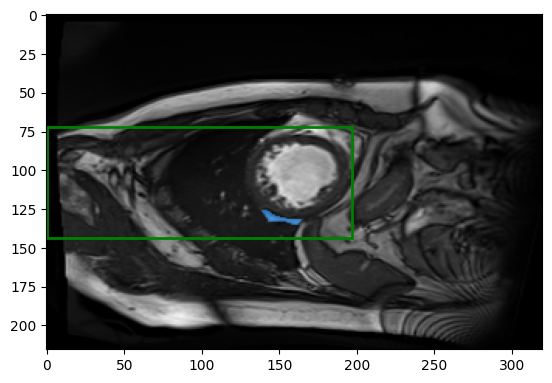

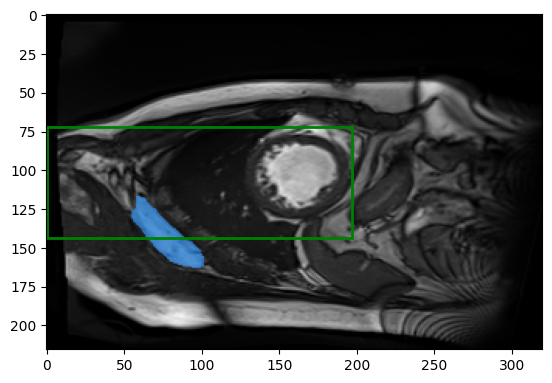

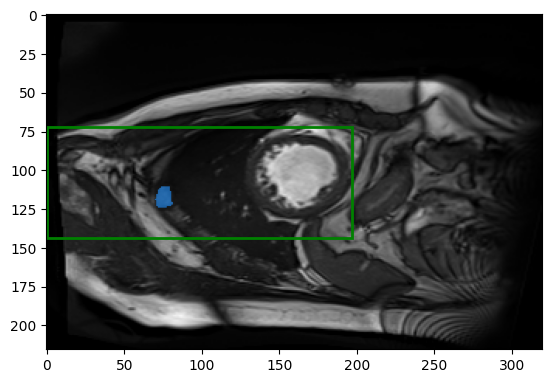

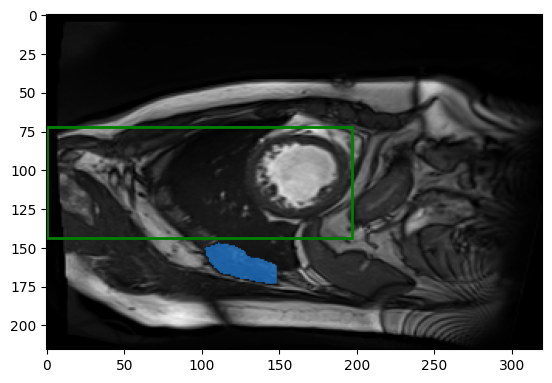

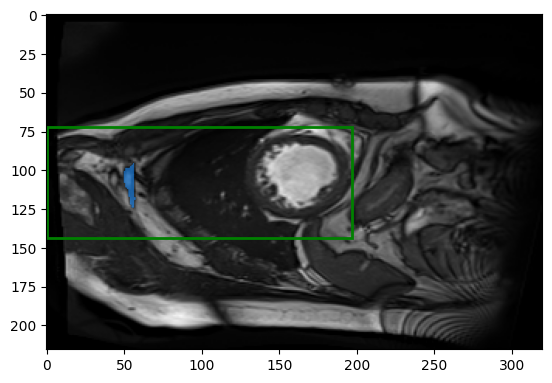

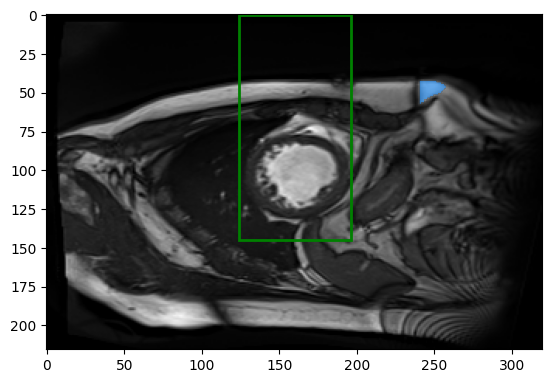

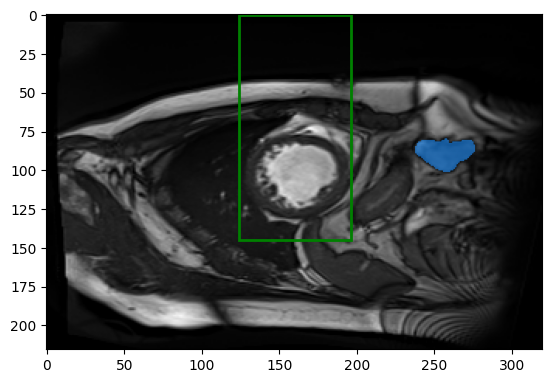

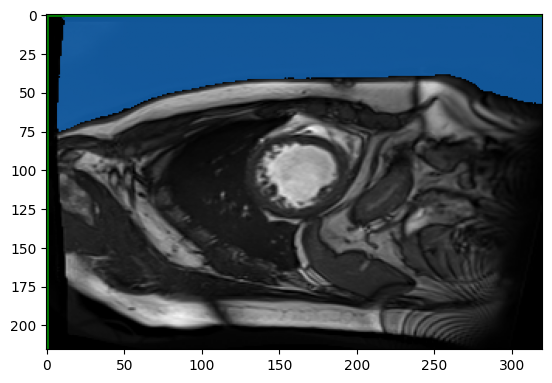

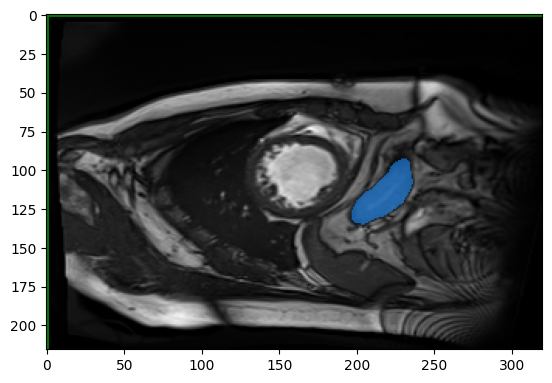

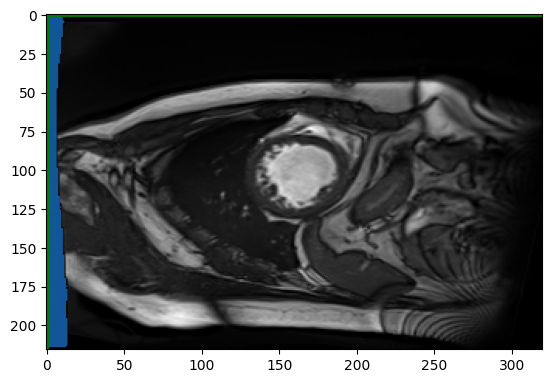

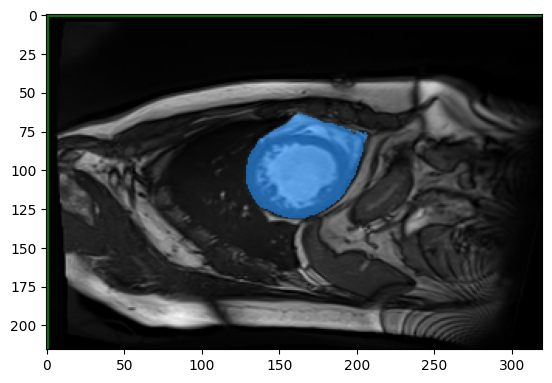

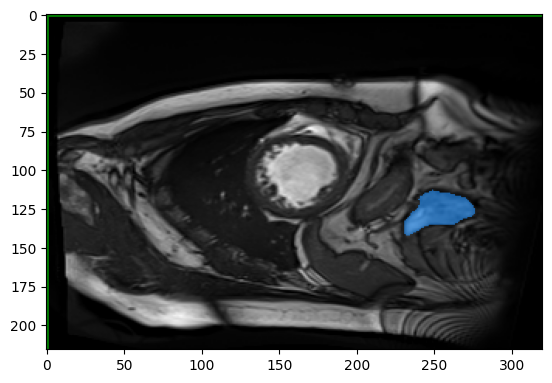

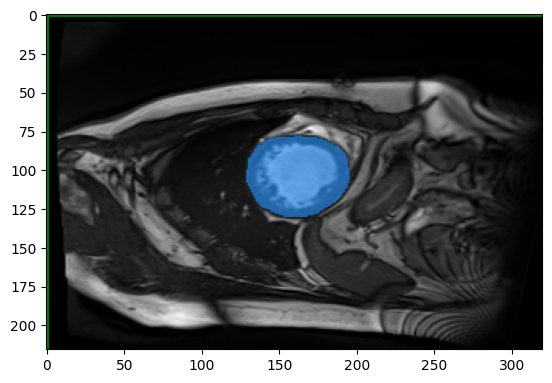

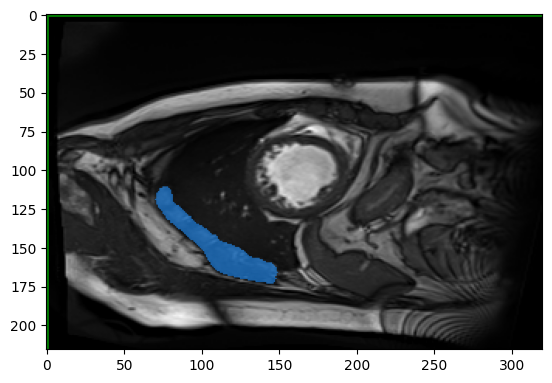

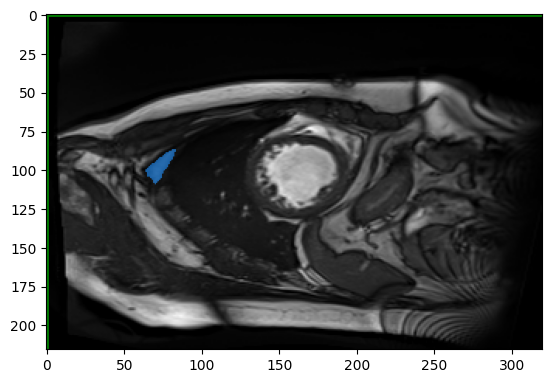

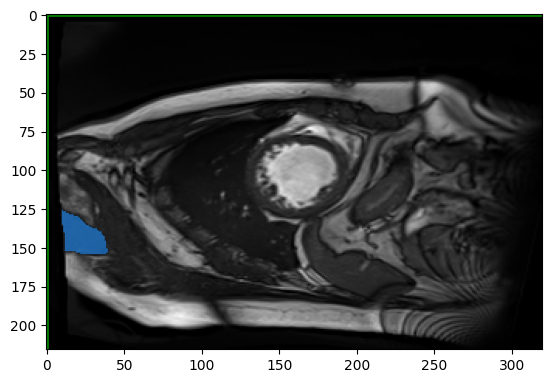

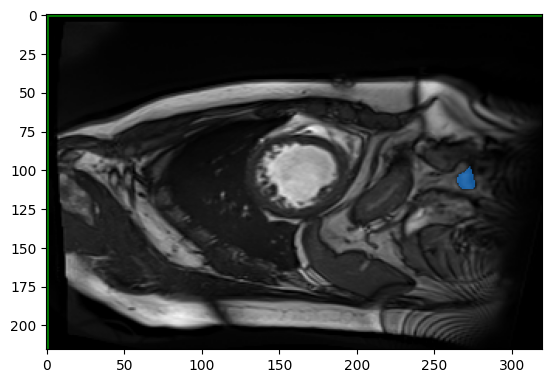

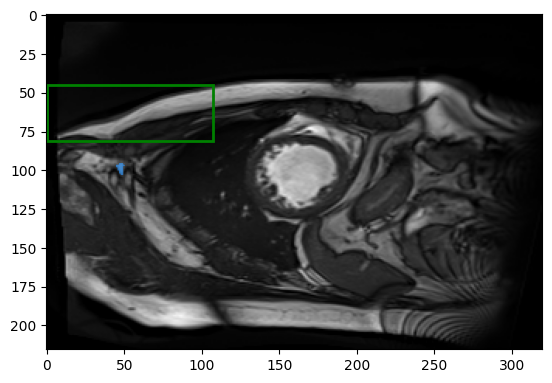

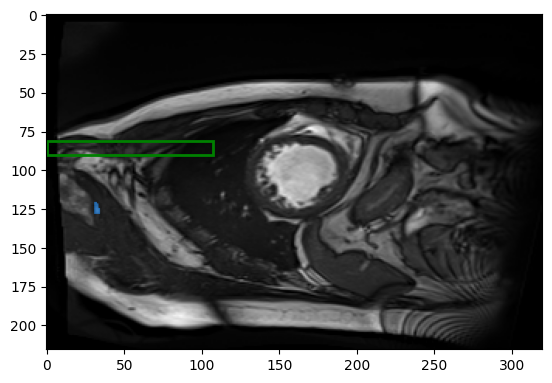

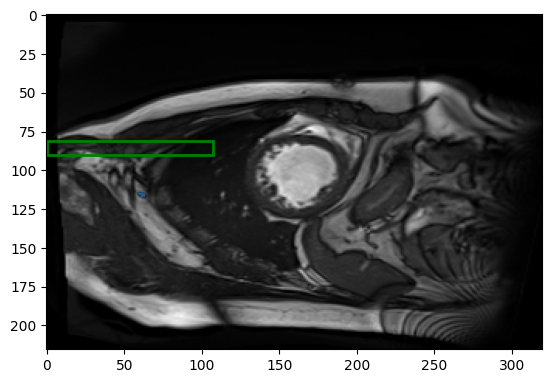

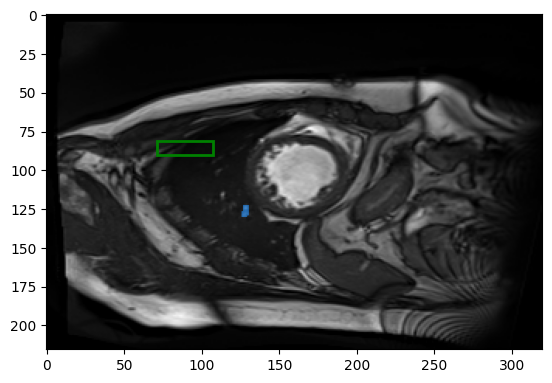

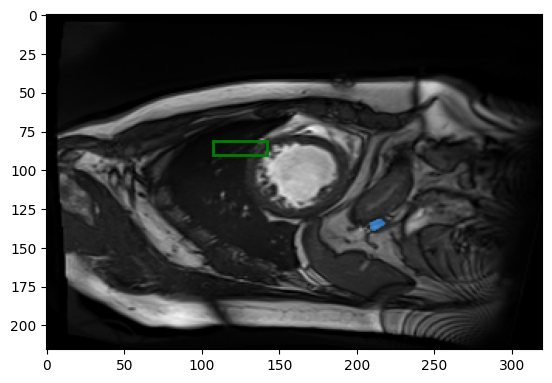

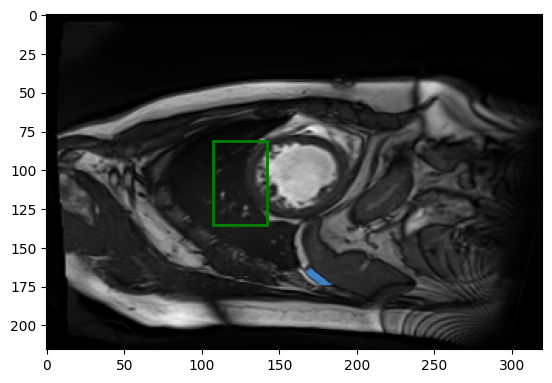

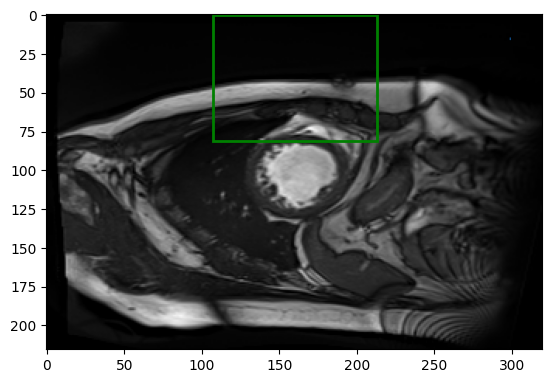

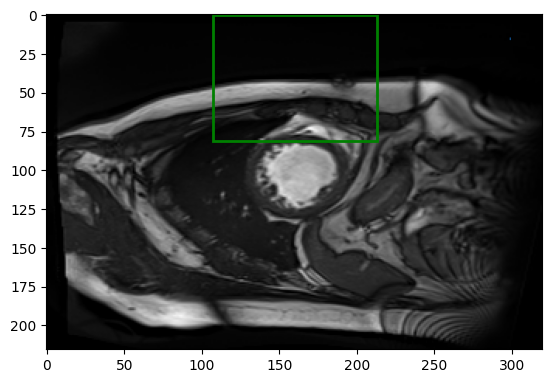

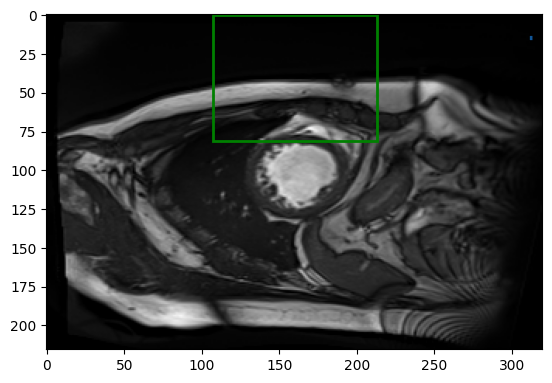

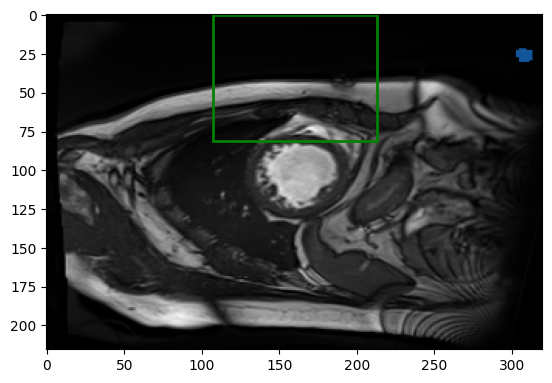

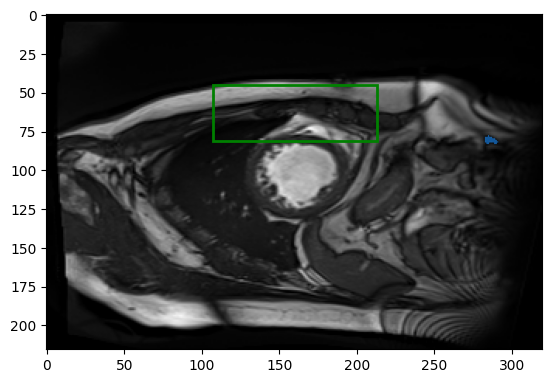

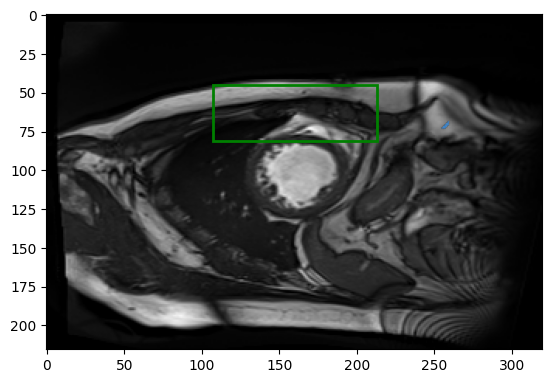

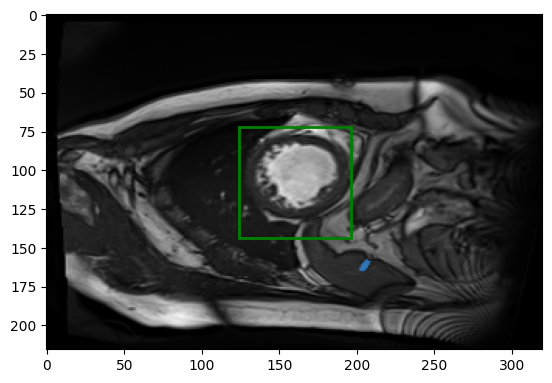

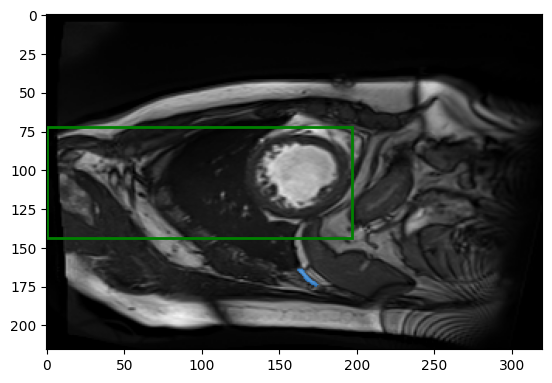

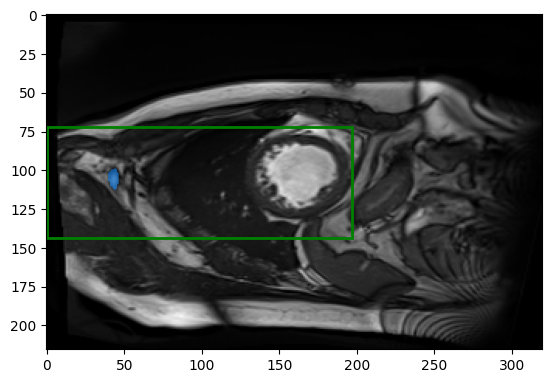

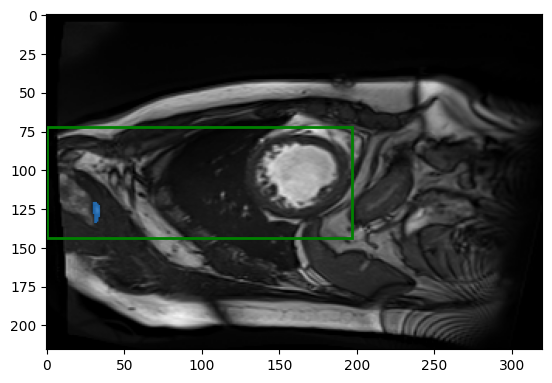

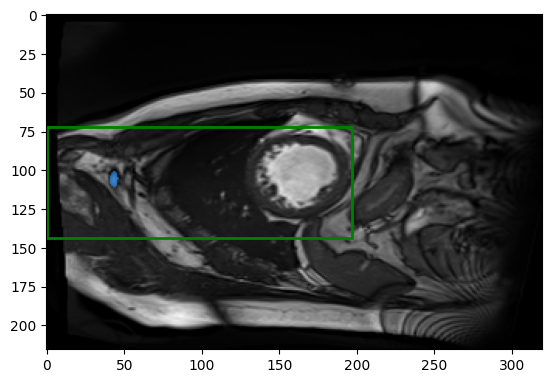

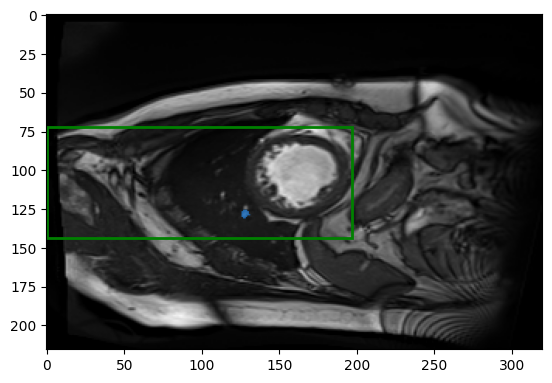

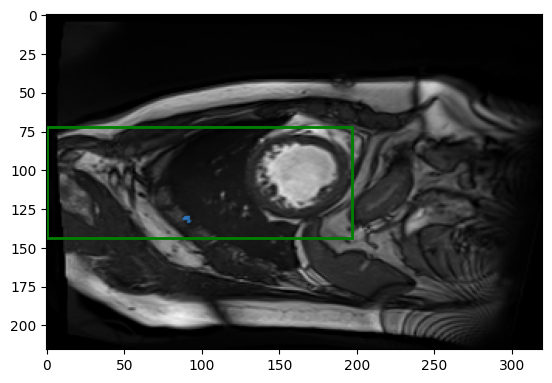

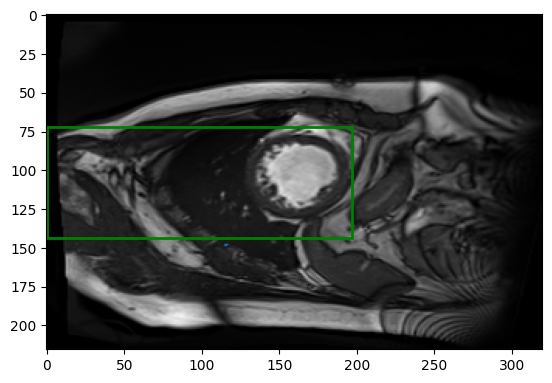

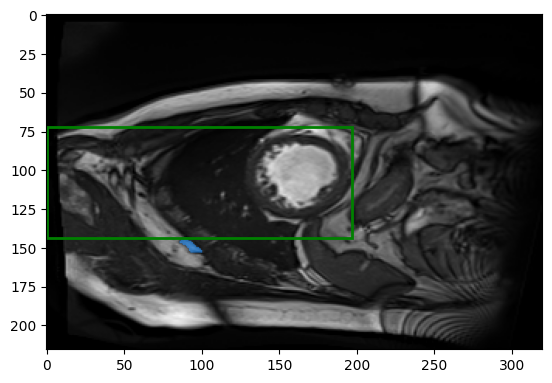

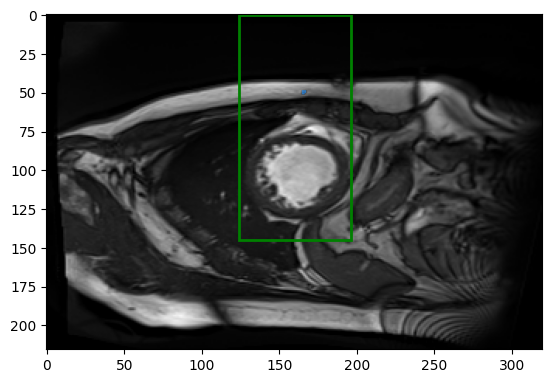

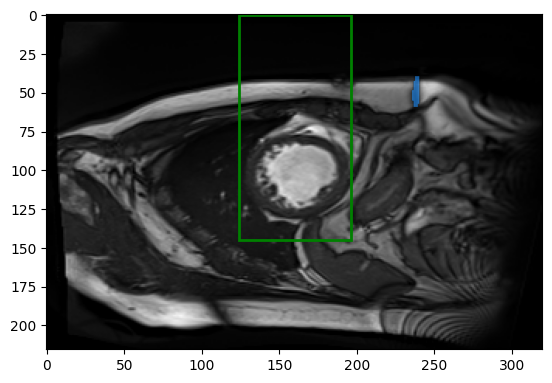

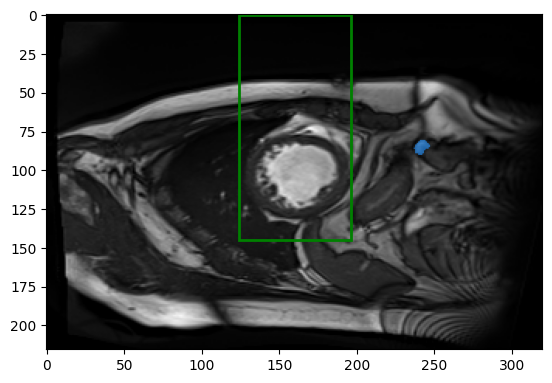

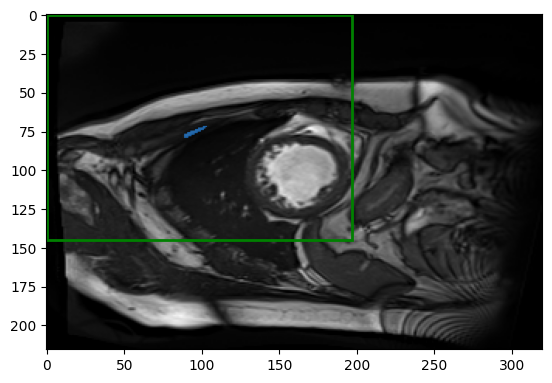

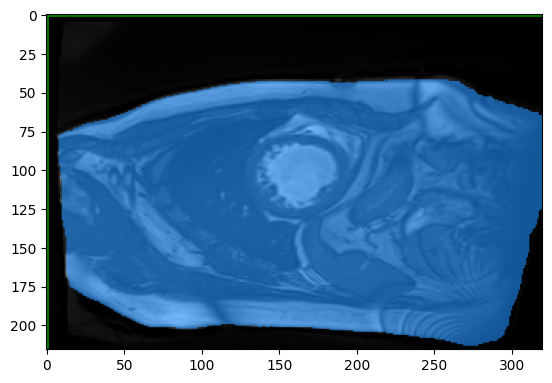

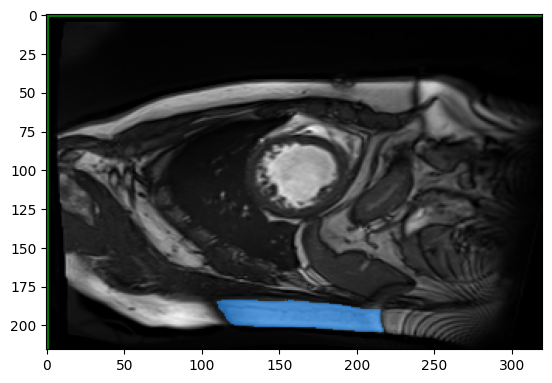

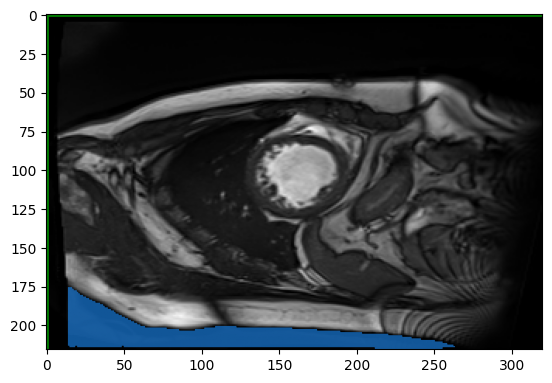

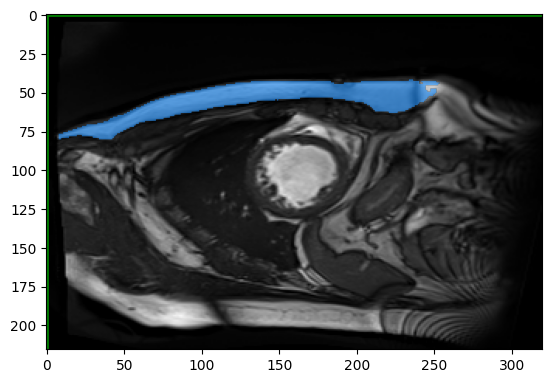

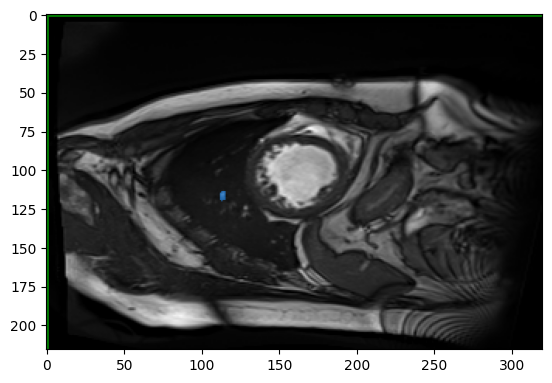

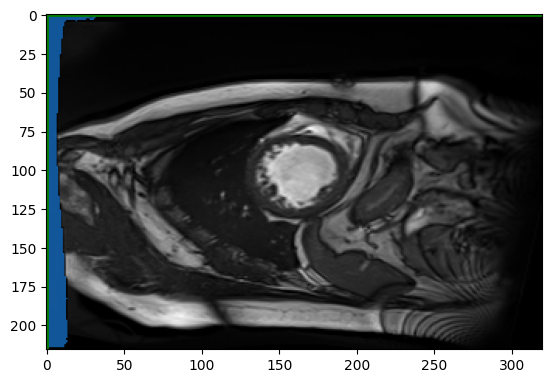

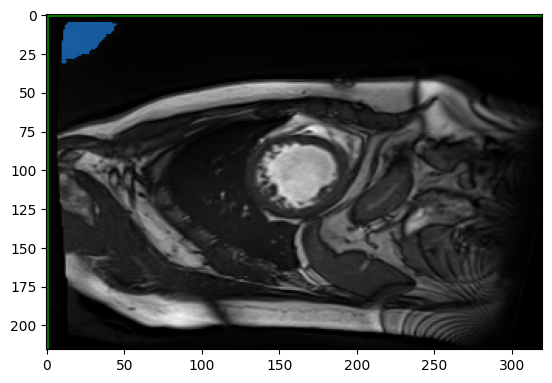

In [34]:
for mask in masks:
    plt.figure()
    plt.imshow(img2)
    show_mask(mask["segmentation"], plt.gca())
    show_box(mask["crop_box"],plt.gca())
    plt.axis('on')
    plt.show() 

In [12]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 45842,
  'bbox': [8, 42, 311, 171],
  'predicted_iou': 1.017377257347107,
  'point_coords': [[225.0, 91.125]],
  'stability_score': 0.9715567231178284,
  'crop_box': [0, 0, 320, 216]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 14849,
  'bbox': [7, 1, 312, 74],
 

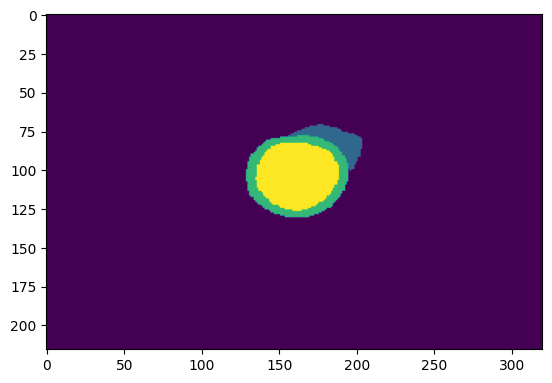

In [13]:
plt.imshow(after_gt[:,:,7])

In [14]:
class_1 = np.where(after_gt[:,:,7] == 1)

In [15]:
class_1[0][:10]

array([71, 71, 71, 71, 72, 72, 72, 72, 72, 72])

In [16]:
class_1[1][:10]

array([175, 176, 177, 178, 170, 171, 172, 173, 174, 175])

In [17]:
import random
def sam_input(gt_image, label: int, n_points: int, input_image = np.array([None]), pixel_values = range(256)):
    '''
    Generates an array of a defined number of sampled points from one class of the gt_image.

    Arguments:
    gt_image: 2D-array, assigned labels of the original image
    label: integer, class to which the sam_points should belong
    n_points: number of points that should be returned
    input_image: array of input image for checking pixel values
    pixel_values: a range of pixel values that sam_points should have
    Returns:
    A numpy array of n points belonging to the label
    '''
    if input_image.any() != None:
        minimum = min(pixel_values)
        maximum = max(pixel_values)
        arr = np.where(gt_image == label,input_image,0)
        rows,cols = np.where((minimum <= arr) & (maximum >= arr))
        points = [[col, row] for row, col in zip(rows,cols)]

    else:
        rows,cols = np.where(gt_image == label)
        points = [[col, row] for row, col in zip(rows,cols)]
    assert len(points) >= n_points, f"Choose the number of points lower than {len(points)}"
    sam_points = np.array(random.sample(points, n_points))
    return sam_points

In [18]:
ground_truth = after_gt[:,:,7]
pos_points_3 = sam_input(ground_truth,3,100,test,range(50,200))
neg_points_3 = sam_input(ground_truth,2,5)

In [19]:
input_points_3 = np.concatenate((pos_points_3,neg_points_3),axis = 0)
input_labels_3 = np.array(([1]*100+[0]*5))
print(input_points_3.shape)

(105, 2)


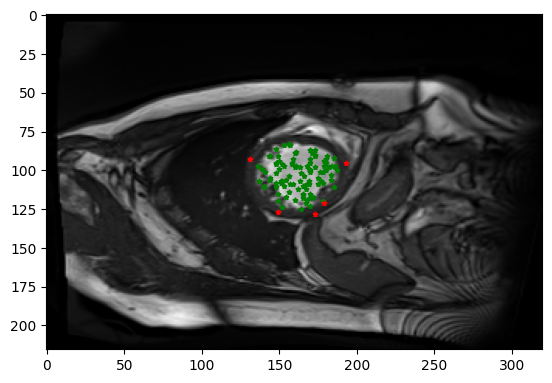

In [20]:
plt.imshow(img2)
show_points(input_points_3 , input_labels_3, ax=plt.gca())
plt.axis('on')
plt.show()  

In [21]:
mask_3, scores, logits = predictor.predict(
                                                                                    point_coords=input_points_3,
                                                                                    point_labels=input_labels_3,
                                                                                    multimask_output=False
                                                                                )

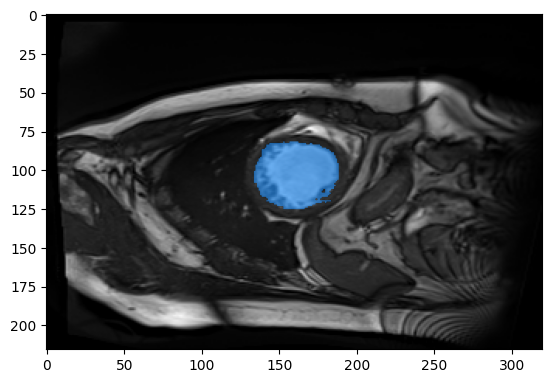

In [22]:
plt.imshow(img2)
show_mask(mask_3, plt.gca())
plt.axis('on')
plt.show()

In [23]:
pos_points_2 = sam_input(ground_truth,2,100)
neg_points_2 = sam_input(ground_truth,3,5)
input_points_2 = np.concatenate((pos_points_2,neg_points_2),axis = 0)
input_labels_2 = np.array([1]*100+[0]*5)
mask_2, scores, logits = predictor.predict(
                                                                                    point_coords=input_points_2,
                                                                                    point_labels=input_labels_2,
                                                                                    multimask_output=False
                                                                                )

In [24]:
pos_points_1 = sam_input(ground_truth,1,100,test,range(50,200))
neg_points_1 = sam_input(ground_truth,2,5)
input_points_1 = np.concatenate((pos_points_1,neg_points_1),axis = 0)
input_labels_1 = np.array([1]*100+[0]*5)
mask_1, scores, logits = predictor.predict(
                                                                                    point_coords=input_points_1,
                                                                                    point_labels=input_labels_1,
                                                                                    multimask_output=False
                                                                                )

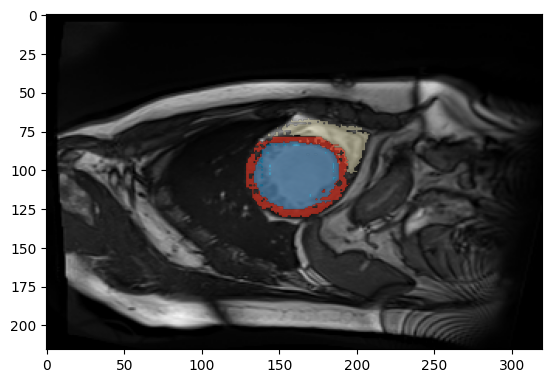

In [25]:
masks = [mask_1,mask_2,mask_3]
plt.imshow(img2)
for mask in masks:
    show_mask(mask, plt.gca(),random_color = True)
plt.axis('on')
plt.show()